## Load libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import time
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import os
from sklearn.metrics import confusion_matrix
import pickle
import os.path
from ipywidgets import interact, widgets
from IPython.display import Image, display, HTML
import glob

## Define training and test sets

In [2]:
def listdir_nohidden(path):
    return glob.glob(os.path.join(path, '*'))
style = {'description_width': 'initial'}


In [3]:
SPECTRUM_IMAGES_ROOT='../GeneratedData/'
SPECTRUM_IMAGES_CLASSESDropdown= widgets.Dropdown(options=listdir_nohidden(SPECTRUM_IMAGES_ROOT), description='Source for Training Data:',style=style)

display(SPECTRUM_IMAGES_CLASSESDropdown)



Dropdown(description='Source for Training Data:', options=('../GeneratedData/Cats-Vs-Dogs', '../GeneratedData/…

## Loading data set
If test set is not defined previously, this function pulls a test set from the training set using a 80/20%split

In [4]:
SPECTRUM_IMAGES_CLASSES_TRAIN = SPECTRUM_IMAGES_CLASSESDropdown.value
SPECTRUM_IMAGES_CLASSES_TEST = ''
INPUT_RESOLUTION = 224
    
transform = transforms.Compose(
    [transforms.Resize(INPUT_RESOLUTION),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset=[]
testset=[]
NoTestSet=False
full_dataset=None
if len(SPECTRUM_IMAGES_CLASSES_TEST)==0:
    print("Using one data set and separating them with an 80%/20% split")
    full_dataset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES_TRAIN, transform=transform)
    full_DataLoader = torch.utils.data.DataLoader(full_dataset, batch_size=4, shuffle=True, num_workers=2)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    trainset, testset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    NoTestSet=True
else:
    print("Using pre-seperated test and training data sets!")
    trainset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES_TRAIN, transform=transform)
    testset = torchvision.datasets.ImageFolder(root=SPECTRUM_IMAGES_CLASSES_TEST, transform=transform)
    

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)
classes=None
if(NoTestSet):
    classes = full_DataLoader.dataset.classes
else:
    classes = trainloader.dataset.classes

print(classes)


Using one data set and separating them with an 80%/20% split
['data']


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Preview sample training images

The following cell takes an entire training batch of images and displays them with their respective labels. Have a look and verify that indeed you see spectrograph images that look similar to what you saw earlier.

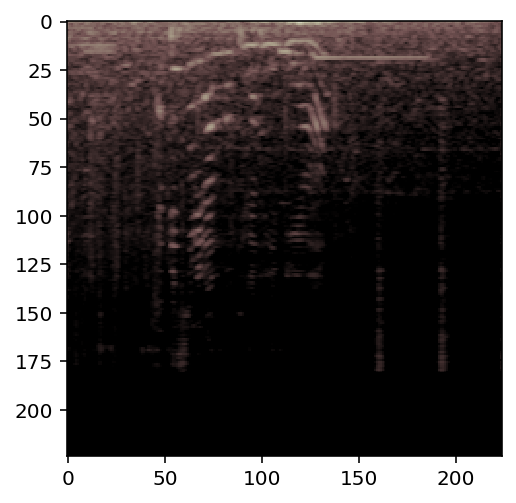

data


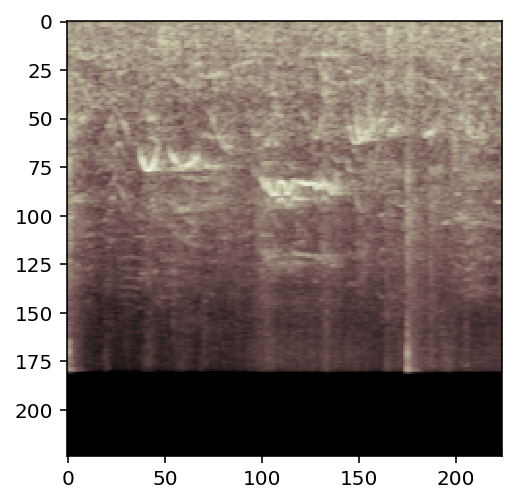

data


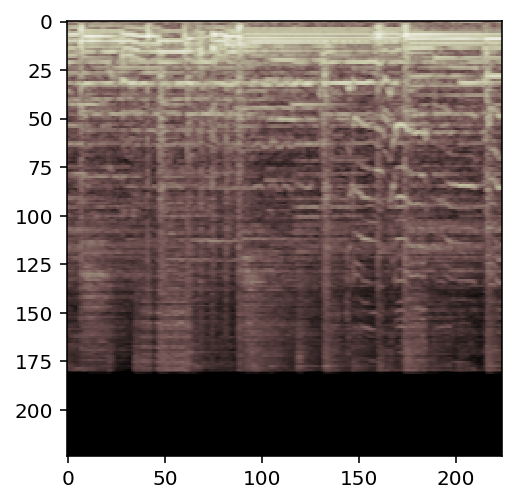

data


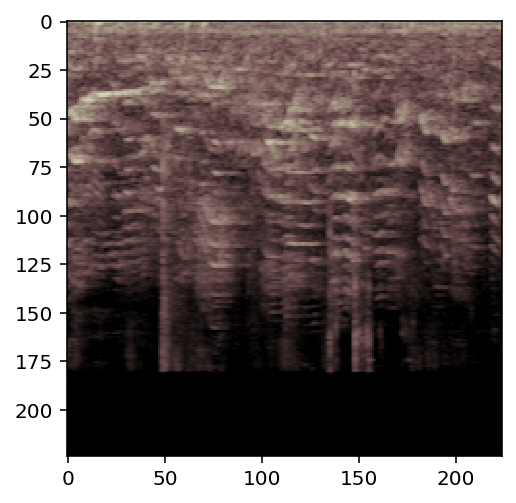

data


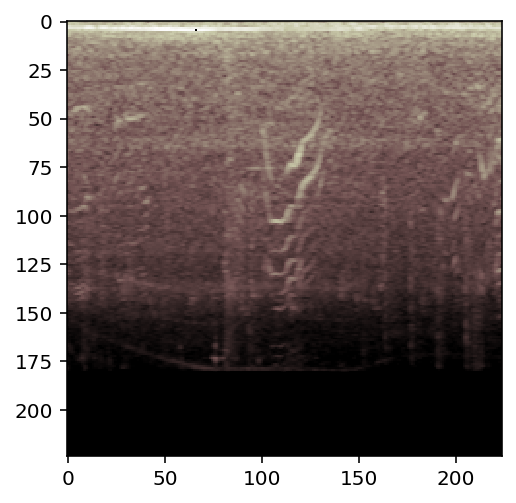

data


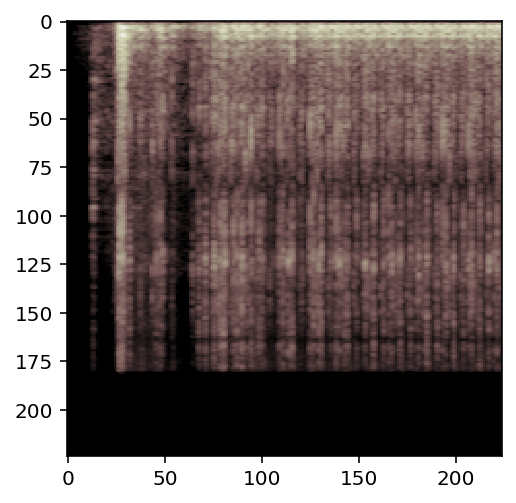

data


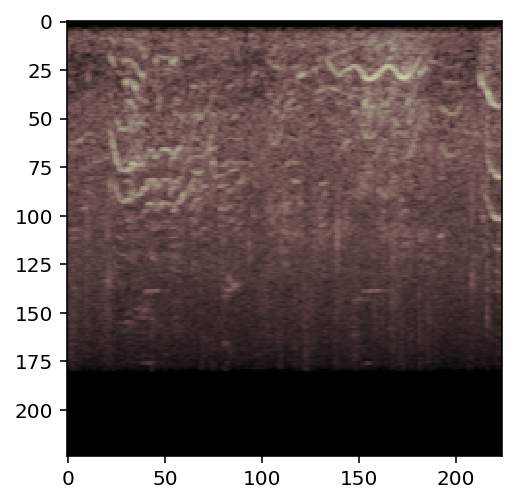

data


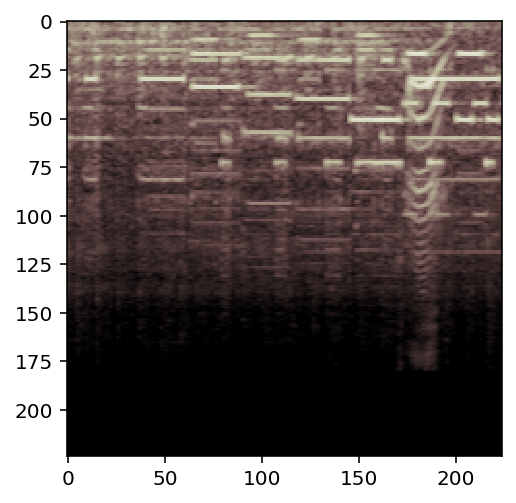

data


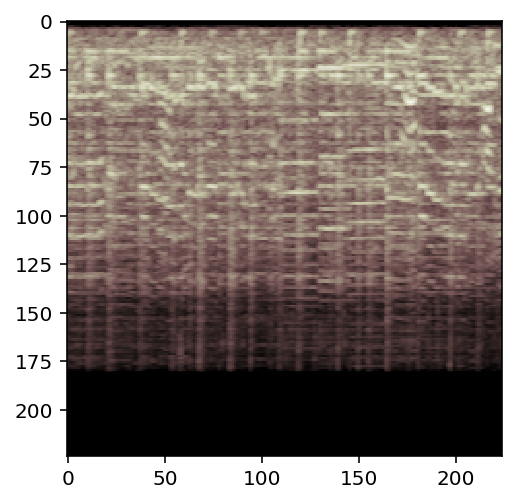

data


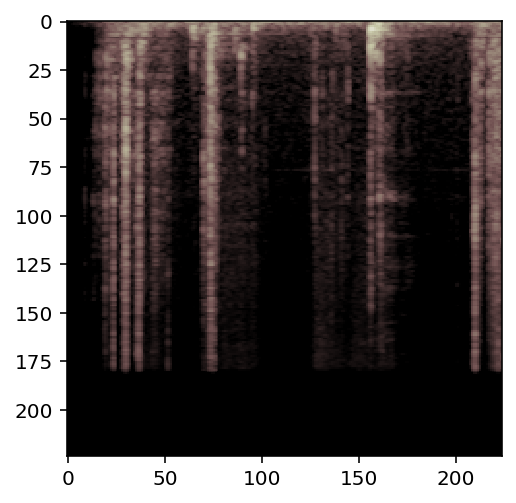

data


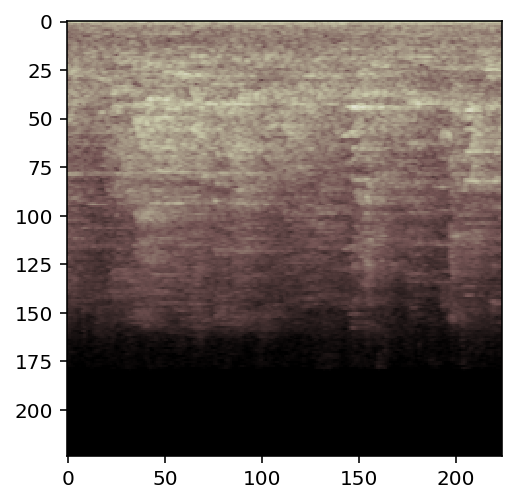

data


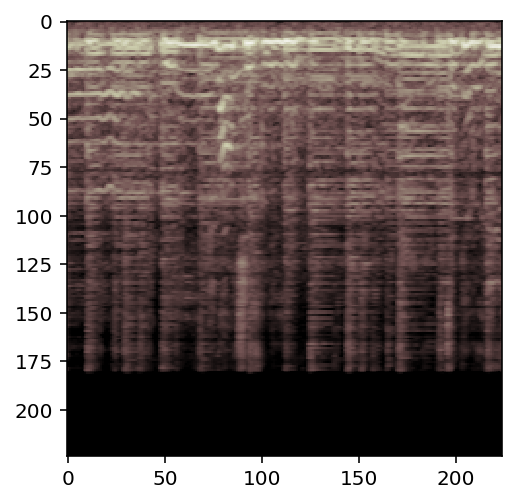

data


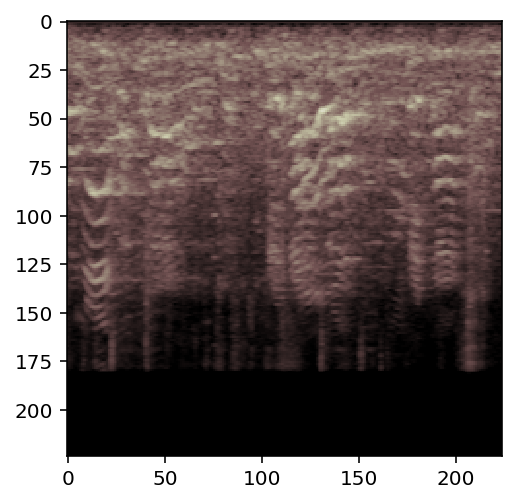

data


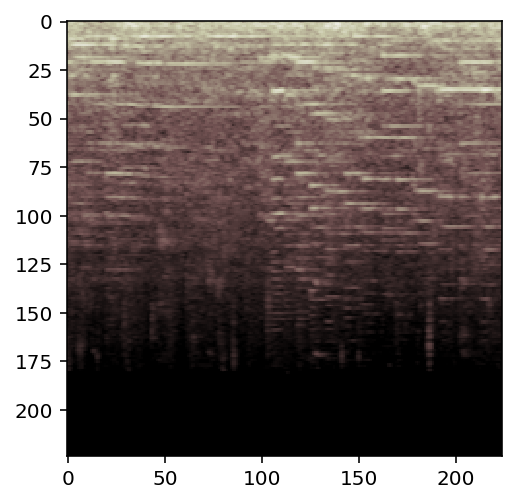

data


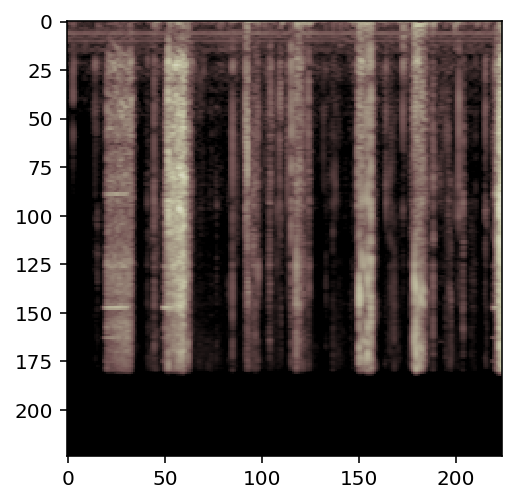

data


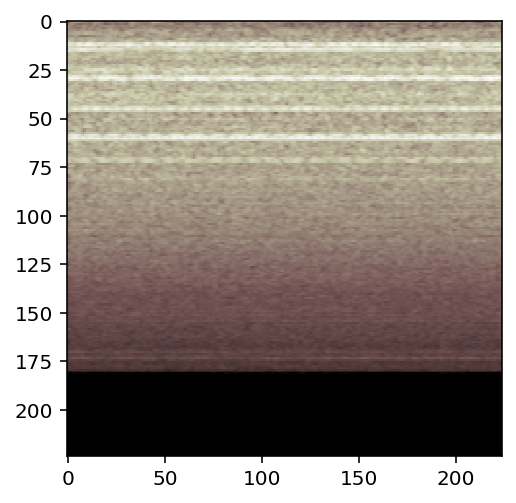

data


In [6]:
#Getting some random training images and showing them
dataiter = iter(trainloader)
images, labels = dataiter.next()
for i in range(trainloader.batch_size):
    imshow(images[i])
    print(classes[labels[i]])

## Specify use of Graphics Card (if there is one) and use ResNet

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=False)

## Load pretrained model 
The model '../Models/MainModelUrban.pth' was trained on the UrbanSound dataset; other models could be specified instead.

In [8]:
ModelData = torch.load('../Models/MainModelUrban.pth',map_location='cpu')
model.load_state_dict(ModelData['model'])
# IncompatibleKeys(missing_keys=[], unexpected_keys=[]) Means it was succesfull

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Cutting off the head
In the following cell, the setting 'param.requires_grad = False' is **the** function that is telling the network to only retrain the last layer. If you set this parameter to True, the training will take much longer, but hopefully be better at predicting. 

In [9]:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, len(classes)) # otherwise change it 

## Move model to GPU (if there is a GPU)

In [10]:
print('device is', device)
if device.type=='cuda':
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_epoch_losses=[]
test_epoch_losses=[]
epoch=0

device is cpu


## Training the network

In [ ]:
#Training the network on the training dataset
for i in range(5):  # loop over the dataset multiple (5) times 
    epoch+=1
    print("Starting epoch:",epoch)
    epochLoss=0.0
    t0 = time.time()
    model.train()
    for i, data in enumerate(trainloader, 0):
        #print("Running Batches",i)
        # get the inputs
        inputs, labels = data
        if device.type=='cuda':
            inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        if((i+i)%200==0):
            if(i>0):
                print('Processed images:',i*trainloader.batch_size,'. Running Timer @ {:.2f}sec.'.format(time.time()-t0))
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epochLoss+=loss.item()
        #break;
    
    model.eval()
    testLoss=0
    print("About to test the performance on the test set.")
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            # get the inputs
            inputs, labels = data
            if device.type=='cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            testLoss+=loss.item()
            if(i%50==0):
                if(i>0):
                    print('Tested images:',i*testloader.batch_size,'. Running Timer @ {:.2f}sec.'.format(time.time()-t0))


    train_epoch_losses.append(epochLoss/len(trainloader))
    test_epoch_losses.append(testLoss/len(testloader))
    EpochLength = time.time()-t0
    print('{} train loss: {:.3f} and test loss: {:.3f}, and it took us: {:.2f} seconds.'.format (epoch + 1, epochLoss / len(trainloader),testLoss/len(testloader),EpochLength))  # DAVID CHanged it to 1000 from 2000 not sure if thats totally done

print('Finished Training')


Starting epoch: 1
Processed images: 1600 . Running Timer @ 112.55sec.
Processed images: 3200 . Running Timer @ 224.68sec.
Processed images: 4800 . Running Timer @ 337.60sec.
Processed images: 6400 . Running Timer @ 450.48sec.
Processed images: 8000 . Running Timer @ 562.63sec.
Processed images: 9600 . Running Timer @ 674.21sec.
Processed images: 11200 . Running Timer @ 786.60sec.
Processed images: 12800 . Running Timer @ 903.69sec.
Processed images: 14400 . Running Timer @ 1026.78sec.
Processed images: 16000 . Running Timer @ 1151.44sec.
Processed images: 17600 . Running Timer @ 1283.33sec.
Processed images: 19200 . Running Timer @ 1405.45sec.
Processed images: 20800 . Running Timer @ 1523.11sec.
Processed images: 22400 . Running Timer @ 1638.30sec.
Processed images: 24000 . Running Timer @ 1761.68sec.
Processed images: 25600 . Running Timer @ 1890.54sec.
Processed images: 27200 . Running Timer @ 2016.77sec.
About to test the performance on the test set.
Tested images: 800 . Running Ti

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 200, in send_by

KeyboardInterrupt: 

## Post training analytics

After the training has finished, save information about the training

In [ ]:
# saving the learnd model in file that can be loaded in for inference
SpectrumVariables = pickle.load(open(os.path.join(SPECTRUM_IMAGES_CLASSES_TRAIN,'Main.SpecVar'), "rb" ) )
torch.save({
    'model':model.state_dict(),
    'classes':classes,
    'resolution':INPUT_RESOLUTION,
    'SpectrumVariables':SpectrumVariables,
    'modelType':"resnet18" # <= If you try out different models make sure to change this too
},"../models/CatDogResNet.pth") # <=Edit file name here 

Display how the traing and test loss progressed over successive epochs

In [ ]:
#Displaying how the loss progresses over time.
plt.plot(train_epoch_losses, label='Training Loss',c='r')
plt.plot(test_epoch_losses, label='Test Loss',c='g')
plt.legend()
plt.show()

Show spectagrams, Predicted and Actual labels.

In [ ]:
# Print predicted and acual labels for Spectragrams
dataiter = iter(testloader)
model.eval()
for j in range (2):
    images, labels = dataiter.next()
    if device == 'cuda':
        images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    for i in range(len(images)):
        imshow(images[i])
        print('GroundTruth: ',classes[labels[i]])
        print('Predicted: ',  classes[predicted[i]])


Print accuracy of test predictions for each label

In [ ]:
# Network analytics
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model.eval()
allLabels=[]
allPrediction=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if (c.dim()==0):
            continue
        for i in range(testloader.batch_size):
            if(len(labels)<=i):
                continue;
            label = labels[i]
            allLabels.append(labels[i].to('cpu').numpy())
            allPrediction.append(predicted[i].to('cpu').numpy())
            #print (c.shape)
            if(testloader.batch_size>1):

                class_correct[label] += c[i].item()
            else:
                class_correct[label] += c.item()
            class_total[label] += 1

print(confusion_matrix(allLabels, allPrediction))
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))